In [7]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate

from sunpy.coordinates.sun import carrington_rotation_time
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error



In [104]:
def read_brier_scores_file(year, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\brier_scores_{year}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_rank_hist_file(year):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\rank_analysis\\rank_hist_{year}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_ROC_scores_file(year, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\forecast_evaluation\\roc_scores_{year}_{int(prob_thresh*10)}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def perturb_longitude(long_pert_dt, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)

def read_in_and_perturb_ensemble(CR_chunk, lat_dev, long_pert_var, ensemble_size, observed_data):

    #initialise rng
    rng = np.random.default_rng()

    #define CR length for later
    carrington_rotation = 27.2753*u.day

    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(observed_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, ensemble_members in enumerate(ensemble_sets):

        lp_ensemble_members = []

        for df in ensemble_members:

            # Perturb ensemble member in longitude
            long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
            long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
            shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

            # resample perturbed ensemble member onto omni data timestep
            Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
            resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
            lp_ensemble_members.append(resampled_shifted_df)
        
        lp_ensemble_sets.append(lp_ensemble_members)

    ## Longitudinally perturbed ensemble members
    combined_lp_ensemble_members = []

    # Create a new list of lists
    for i in range(ensemble_size):
        list_of_cr_members = [sublist[i]['vsw'] for sublist in lp_ensemble_sets]
        combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

    return combined_lp_ensemble_members, combined_data

def compute_calibration_curve(ensemble_members, observed_data, event_threshold, num_bins):
    

    probabilistic_forecast = eef.gen_probabilistic_forecast(ensemble_members=ensemble_members, 
                                                            threshold=event_threshold, ensemble_size=len(ensemble_members))
    y_prob = probabilistic_forecast
    y_true = eef.generate_catagorical_forecast(forecast=observed_data, threshold=event_threshold)

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=num_bins, strategy = 'quantile')

    return (prob_true, prob_pred)


In [3]:
# solar cycle years
year_list = np.arange(2009,2020)

# CR contained within each year
CR_year_dict = {2009:np.arange(2079,2092),
                2010:np.arange(2092,2106),
                2011:np.arange(2106,2119),
                2012:np.arange(2119,2133),
                2013:np.arange(2133,2146),
                2014:np.arange(2146,2159),
                2015:np.arange(2159,2173),
                2016:np.arange(2173,2186),
                2017:np.arange(2186,2200),
                2018:np.arange(2200,2213),
                2019:np.arange(2213,2226)}

# Details to find data
event_threshold = 500
probability_threshold = 0.5

# Read in data
rank_histogram_grids = [read_rank_hist_file(year) for year in year_list]
briers_scores_grids = [read_brier_scores_file(year, event_threshold) for year in year_list]
ROC_scores_grids = [read_ROC_scores_file(year, probability_threshold) for year in year_list]

In [4]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

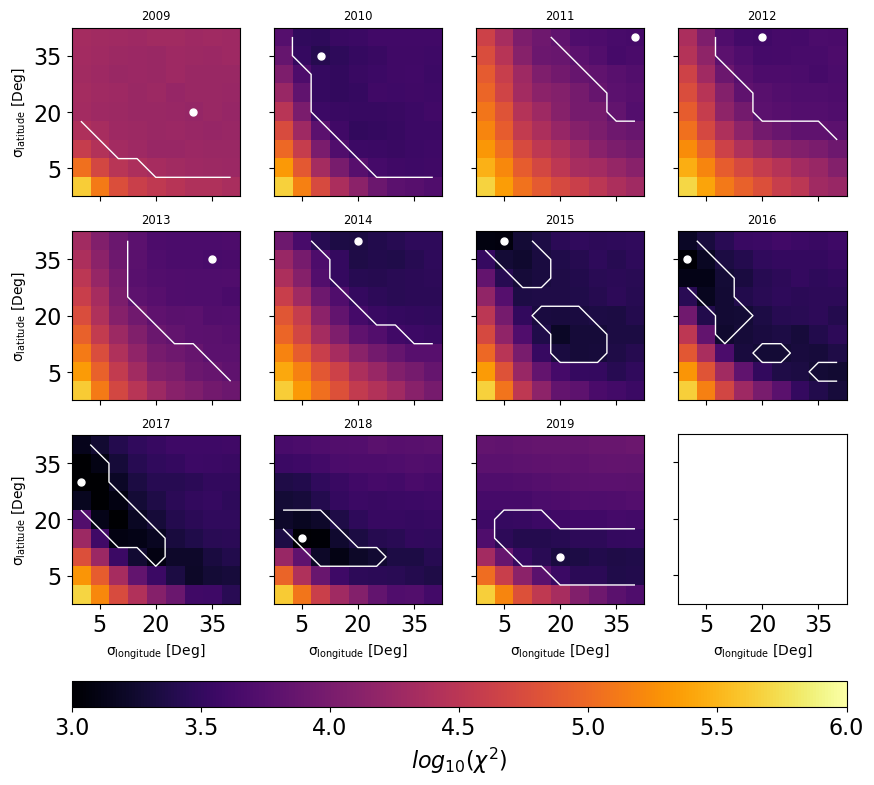

In [5]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i in range(len(year_list)):

    year = year_list[i]
    rank_hist = rank_histogram_grids[i]
    CR_chunk = CR_year_dict[year]

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.1
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3, vmax = 6) 
    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{5^th percentile range}$')
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')
    axes[i].set_title(f'{year}', fontsize = 'small')

outer_y_index = [0,4,8]
for y in outer_y_index:
    axes[y].set_yticks(np.arange(len(lat_dev_list))[1::3])
    axes[y].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
    axes[y].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = np.arange(8,12,1)
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')

plt.show()

In [9]:
# perturbation parameters
lat_dev_list = np.linspace(0,40,9)
long_dev_list = np.linspace(0,40,9)

# list to store rank histogram minima in parameter space
parameter_minima = []

# finding associated lat/long parameters for minima in chi squared grid
for grid in rank_histogram_grids:
    min_index = np.argmin(grid)
    parameter_minima.append((int(np.meshgrid(lat_dev_list, long_dev_list)[1].flatten()[min_index]), 
    int(np.meshgrid(lat_dev_list, long_dev_list)[0].flatten()[min_index])))


In [112]:
parameter_minima = []
for i, year in enumerate(year_list):
    parameter_minima.append((20,15))

In [114]:
best_ensemble_sets = []
data_sets = []

for i, _ in enumerate(year_list):

    year_idx = i
    year = year_list[year_idx]
    CR_chunk = CR_year_dict[year] # one year of carrington rotations

    lat_dev = parameter_minima[year_idx][0] # degrees
    long_dev = parameter_minima[year_idx][1] # degrees

    carrington_rotation = 27.2753*u.day
    ensemble_size = 100

    ensemble_members, observed_data = read_in_and_perturb_ensemble(CR_chunk=CR_year_dict[year], lat_dev=lat_dev, 
                                                                long_pert_var=long_dev, ensemble_size=ensemble_size,
                                                                observed_data=omni_data['V'])
    best_ensemble_sets.append(ensemble_members)
    data_sets.append(observed_data)




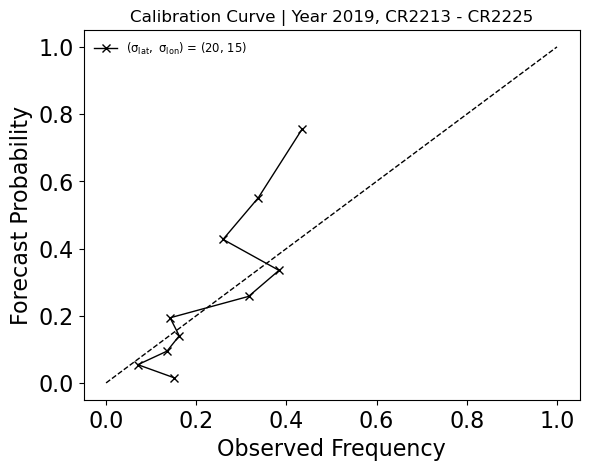

In [115]:
num_bins = 10
observed_data = data_sets[6]
ensemble_members = best_ensemble_sets[6]

ensemble_cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=observed_data, 
                                                event_threshold=event_threshold, num_bins=num_bins)

lat_dev, long_dev = parameter_minima[6]
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.plot(ensemble_cal_curve[0], ensemble_cal_curve[1], marker = 'x', color = 'black', lw = 1,
         label = f'($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev})')

plt.legend()

plt.xlabel('Observed Frequency')
plt.ylabel('Forecast Probability')
plt.title(f'Calibration Curve | Year {year}, CR{CR_chunk[0]} - CR{CR_chunk[-1]}')
plt.legend(frameon = False, fontsize = 'small')
plt.show()

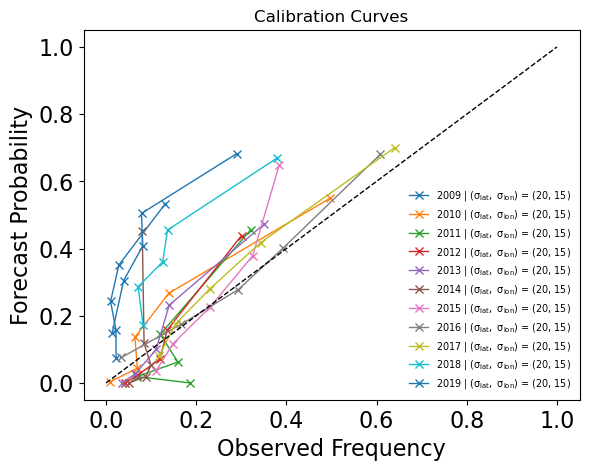

In [137]:
num_bins = 5

all_best_cal_curves = []
for i, ensemble_members in enumerate(best_ensemble_sets):

    ensemble_cal_curve = compute_calibration_curve(ensemble_members=ensemble_members, observed_data=data_sets[i], 
                                                    event_threshold=event_threshold, num_bins=num_bins)
    all_best_cal_curves.append(ensemble_cal_curve)

    lat_dev, long_dev = parameter_minima[i]
    plt.plot(ensemble_cal_curve[0], ensemble_cal_curve[1], marker = 'x', lw = 1,
         label = f'{year_list[i]} | ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev})')

plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')


plt.xlabel('Observed Frequency')
plt.ylabel('Forecast Probability')
plt.title(f'Calibration Curves')
plt.legend(frameon = False, fontsize = 'x-small')
plt.show()

In [ ]:
calibration_err = np.

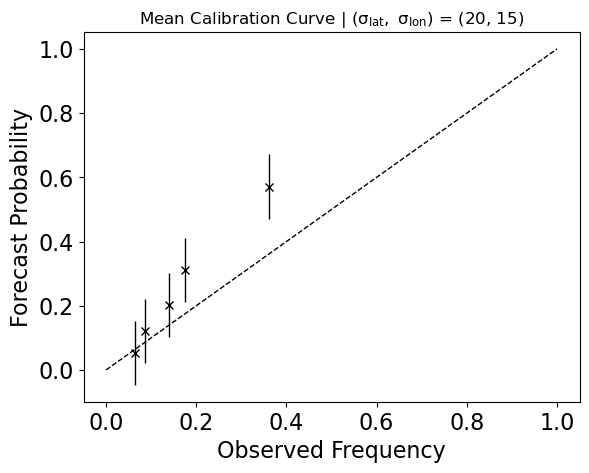

In [147]:
mean_cal_curve = np.mean(all_best_cal_curves, axis = 0)
lat_dev = 20
long_dev = 15

plt.errorbar(mean_cal_curve[0], mean_cal_curve[1], yerr= 0.1, marker = 'x', lw = 1, color = 'black', linestyle = '')
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2), lw = 1, linestyle = '--', color = 'black')

plt.xlabel('Observed Frequency')
plt.ylabel('Forecast Probability')
plt.title(f'Mean Calibration Curve | ($\mathrm{{\sigma_{{lat}},~\sigma_{{lon}}}}$) = ({lat_dev}, {long_dev})')
#plt.legend(frameon = False, fontsize = 'x-small')
plt.show()